In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder

from scipy.stats import chi2_contingency

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential 
from keras.layers import Dense
from keras.initializers import GlorotUniform
from keras.initializers import HeUniform
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adamax, Nadam, Ftrl

import hyperopt
from hyperopt import hp, fmin, tpe, Trials, space_eval, STATUS_OK

#ignore warnings
import warnings
warnings.filterwarnings('ignore')
print('-'*25)

TEST_SIZE = 0.2


2024-09-22 17:54:38.902461: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-22 17:54:39.309414: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-22 17:54:39.309472: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-22 17:54:39.310955: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-22 17:54:39.533524: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-22 17:54:39.536899: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

-------------------------


In [2]:
# Import del dataset e divisione in train e test
df = pd.read_csv('datasets/ObesityDataSet.csv')
# Sostituire la colonna 'NObeyesdad' con il risultato della seguente formula: Weight/(Height^2)
df['NObeyesdad'] = ((df['Weight']) / (df['Height']**2))
df.rename(columns={'NObeyesdad': 'label'}, inplace=True)

# Viene diviso il train set in train e validation set
train_df, test_df = train_test_split(df, test_size = TEST_SIZE, random_state = 42)
train_df, val_df = train_test_split(train_df, test_size = TEST_SIZE, random_state = 42)

train_x = train_df.drop(columns=['label'])
train_y = train_df['label'].astype('float64')

val_x = val_df.drop(columns=['label'])
val_y = val_df['label'].astype('float64')

test_x = test_df.drop(columns=['label'])
test_y = test_df['label'].astype('float64')

In [3]:
cat_cols = train_x.select_dtypes(include='object').columns
num_cols = train_x.select_dtypes(exclude='object').columns

scaler = StandardScaler()
train_x[num_cols] = scaler.fit_transform(train_x[num_cols])

# Applica l'encoding ai dati categoriali nella lista ord_list
encoder = OrdinalEncoder()
train_x[cat_cols] = encoder.fit_transform(train_x[cat_cols])

def fs(dataset, dataset_y):
    str_path = 'objects/features_obesity.npy'
    #controllare se esiste il file features.npy
    if not os.path.exists(str_path):
        dataset['label'] = dataset_y
        correlation_matrix=dataset.corr()
        features = correlation_matrix['label'][(correlation_matrix['label']>=0.1) | (correlation_matrix['label']<=-0.1)].index
        features = features.drop('label')
        print(correlation_matrix['label'].sort_values(ascending=False))
        print(features)
        np.save(str_path, features)
    features = np.load(str_path, allow_pickle=True)
    return train_x[features]

#se la colonna ha solo due valori diversi fare one hot encoding
def one_hot_encoding(dataset):
    for column in dataset.columns:
        if len(dataset[column].unique()) <= 2:
            dataset = pd.get_dummies(dataset, columns=[column])
    return dataset.astype('float64')

train_x = fs(train_x, train_y)
train_x = one_hot_encoding(train_x)

In [4]:
def preproc_test_val(dataset, scaler, encoder):
    cat_cols = dataset.select_dtypes(include='object').columns
    num_cols = dataset.select_dtypes(exclude='object').columns
    dataset[num_cols] = scaler.transform(dataset[num_cols])
    dataset[cat_cols] = encoder.transform(dataset[cat_cols])
    features = np.load('objects/features_obesity.npy', allow_pickle=True)
    dataset = dataset[features]
    dataset = dataset.astype(float)
    dataset = one_hot_encoding(dataset)
    return dataset

val_x = preproc_test_val(val_x, scaler, encoder)
test_x = preproc_test_val(test_x, scaler, encoder)

# salvare train e test set preprocessati su csv
train_df = pd.concat([train_x, train_y], axis=1)
train_df.to_csv('datasets/train_obesity.csv', index=False)
test_df = pd.concat([test_x, test_y], axis=1)
test_df.to_csv('datasets/test_obesity.csv', index=False)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1920      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 1)                 6

2024-09-22 17:54:43.419144: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-22 17:54:43.423926: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/1000
6/6 [==============================] - 1s 81ms/step - loss: 653.0991 - mean_squared_error: 653.0991 - val_loss: 134.4344 - val_mean_squared_error: 134.4344
Epoch 2/1000
6/6 [==============================] - 0s 12ms/step - loss: 304.9225 - mean_squared_error: 304.9225 - val_loss: 559.3635 - val_mean_squared_error: 559.3635
Epoch 3/1000
6/6 [==============================] - 0s 11ms/step - loss: 465.5243 - mean_squared_error: 465.5243 - val_loss: 94.0114 - val_mean_squared_error: 94.0114
Epoch 4/1000
6/6 [==============================] - 0s 10ms/step - loss: 145.0498 - mean_squared_error: 145.0498 - val_loss: 10.8418 - val_mean_squared_error: 10.8418
Epoch 5/1000
6/6 [==============================] - 0s 9ms/step - loss: 67.2048 - mean_squared_error: 67.2048 - val_loss: 55.0650 - val_mean_squared_error: 55.0650
Epoch 6/1000
6/6 [==============================] - 0s 9ms/step - loss: 47.7424 - mean_squared_error: 47.7424 - val_loss: 29.0968 - val_mean_squared_error: 29.0968


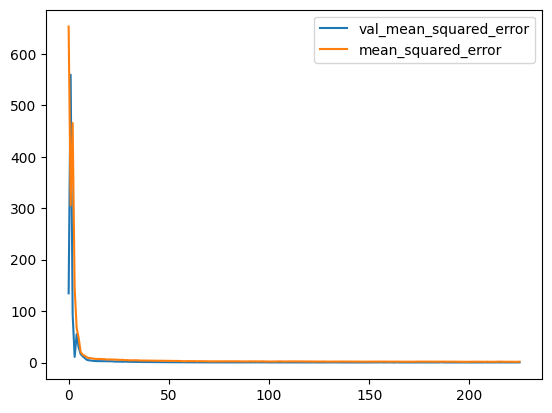

In [5]:
EPOCHS = 1000
BATCH_SIZE = 256
DROPOUT = 0.1
np.random.seed(42)
tf.random.set_seed(42)
loss_str = 'mean_squared_error'
# Initialising the NN
model = Sequential()

model.add(Dense(128, kernel_initializer='normal',input_dim = train_x.shape[1], activation='relu'))
model.add(Dropout(DROPOUT))
model.add(Dense(256, kernel_initializer='normal',activation='relu'))
model.add(Dropout(DROPOUT))
model.add(Dense(128, kernel_initializer='normal',activation='relu'))
model.add(Dense(64, kernel_initializer='normal',activation='relu'))
model.add(Dense(1, kernel_initializer='normal',activation='linear'))

model.summary()

initial_learning_rate = 0.01
final_learning_rate = 0.0001
learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/EPOCHS)
steps_per_epoch = int(train_x.shape[0]/BATCH_SIZE)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=steps_per_epoch,
    decay_rate=learning_rate_decay_factor,
    staircase=True)
model.compile(optimizer = keras.optimizers.Adam(learning_rate=lr_schedule), loss = loss_str, metrics = [loss_str])

# Train the NN
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20, min_delta=0.0001, restore_best_weights=True)

history = model.fit(train_x, train_y,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=[early_stopping_cb],
                    validation_data=(val_x, val_y))

print(history.history.keys())
plt.plot(history.history['val_'+loss_str])
plt.plot(history.history[loss_str])
plt.legend(['val_'+loss_str, loss_str])
plt.show()


In [6]:
score = model.evaluate(test_x, test_y)
print(score[0])

 1/14 [=>............................] - ETA: 0s - loss: 0.0301 - mean_squared_error: 0.0301

14/14 [==============================] - 0s 2ms/step - loss: 0.0482 - mean_squared_error: 0.0482
0.04820840805768967
0.04820840805768967
